In [132]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [6]:
data_path = 'dataset/'
customer_train = pd.read_csv(f'{data_path}customer_train.csv')
customer_test = pd.read_csv(f'{data_path}customer_test.csv')
stories_description = pd.read_csv(f'{data_path}stories_description.csv')
stories_reaction_test = pd.read_csv(f'{data_path}stories_reaction_test.csv')
stories_reaction_train = pd.read_csv(f'{data_path}stories_reaction_train.csv')
transactions = pd.read_csv(f'{data_path}transactions.csv')


sample_submit = pd.read_csv(f'{data_path}sample_submit.csv')



In [15]:
stories_reaction_train.head(3)

,customer_id,story_id,event_dttm,event
0,15,138,2018-07-24 15:33:22,view
1,15,202,2018-06-04 08:08:08,skip
2,15,222,2018-06-17 13:44:45,skip


In [14]:
stories_reaction_test.head(3)

,customer_id,story_id,event_dttm,answer_id
0,466906,1152,2018-08-01 00:00:46,0
1,466906,1355,2018-08-01 00:00:46,1
2,146395,537,2018-08-01 00:02:08,2


In [20]:
sample_submit.head(3)

,answer_id,score
0,0,0.85
1,1,0.53
2,2,-0.89


In [17]:
customer_train.head(3)

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0.0,2018-03-20 09:10:16,1,Неруководящий сотрудник - обсл. Персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0.0,2017-03-29 20:38:45,16,NaN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0.0,2018-03-12 11:25:06,22,NaN


In [18]:
customer_test.head(3)

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,234305,NaN,NaN,NaN,NaN,NaN,UTL,NaN,F,25.0,NaN,0.0,2015-10-29 09:59:10,22,Менеджер проектов
1,914339,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,15.0,NaN,0.0,2018-04-09 08:51:54,22,NaN
2,895631,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,20.0,NaN,0.0,2018-03-22 10:38:33,16,Менеджер по продажам


In [19]:
transactions.head(3)

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc
0,855115,7,3,1500,4554547,5411
1,997036,6,6,0,1657528,5411
2,398237,5,24,2500,26375569,5813


In [21]:
stories_description.head(3)

,story_id,story_json
0,127,"{""guid"":""770a5bae-0e3f-4a6b-b924-bd87bd51a038""..."
1,254,"{""guid"":""64f4c9ef-647b-4e04-b4d4-02297e939388""..."
2,865,"{""guid"":""3482206b-d223-4aec-92ba-0150055cd68a""..."


# Customers files review

In [32]:
train_customer_ids = set(customer_train.customer_id.values)
test_customer_ids = set(customer_test.customer_id.values)
print(f"train customer count {len(train_customer_ids)}")
print(f"test customer count {len(test_customer_ids)}")
print(f"intersection customer count {len(train_customer_ids.intersection(test_customer_ids))}")

train customer count 50000
test customer count 54245
intersection customer count 50000


Test includes all train ids. Lets check if data the same

In [50]:
customer_test_subset = customer_test[customer_test.customer_id.isin(train_customer_ids)].reset_index(drop=True)
customer_test_subset.equals(customer_train)

False

there is a difference, lets find in

In [83]:
def pd_column_diff(column_name, return_count = 1):
    test_field = customer_test_subset[['customer_id', column_name]]
    train_field = customer_train[['customer_id', column_name]]
    diff = pd.concat([test_field,train_field]).drop_duplicates(keep=False)
    print(f'{column_name} diff_count = {len(diff)}')
    return list(diff.customer_id)[:return_count]

In [84]:
for column in list(customer_train.columns)[1:]:
    pd_column_diff(column, 0)

product_0 diff_count = 320
product_1 diff_count = 1922
product_2 diff_count = 1368
product_3 diff_count = 1448
product_4 diff_count = 1328
product_5 diff_count = 2884
product_6 diff_count = 418
gender_cd diff_count = 278
age diff_count = 3842
marital_status_cd diff_count = 2234
children_cnt diff_count = 716
first_session_dttm diff_count = 0
job_position_cd diff_count = 7792
job_title diff_count = 9846


lets check it

In [91]:
children_cnt_id = pd_column_diff('children_cnt')[0]
print(customer_train[customer_train.customer_id == children_cnt_id].children_cnt)
print(customer_test[customer_test.customer_id == children_cnt_id].children_cnt)

children_cnt diff_count = 716
37301    0.0
Name: children_cnt, dtype: float64
209    1.0
Name: children_cnt, dtype: float64


Hmmm... found difference. Must be the provided customer state is at the reaction moment

In [152]:
stories_reaction_train_ids = set(stories_reaction_train.customer_id)
stories_reaction_test_ids = set(stories_reaction_test.customer_id)
print(f"count customer who made reaction in train {len(stories_reaction_train_ids)}")
print(f"count customer who made reaction in test {len(stories_reaction_test_ids)}")
print(f"intersection customers who made reaction {len(stories_reaction_train_ids.intersection(stories_reaction_test_ids))}")
all_customers_in_train_test = stories_reaction_train_ids.union(stories_reaction_test_ids)
print(f"union customers who made reaction {len(all_customers_in_train_test)}")

count customer who made reaction in train 41001
count customer who made reaction in test 22646
intersection customers who made reaction 14260
union customers who made reaction 49387


So why do they provide 54245 customers if there are only 49387 who made reaction??

In [142]:
stories_reaction_train_ids = set(stories_reaction_train.story_id)
stories_reaction_test_ids = set(stories_reaction_test.story_id)
print(f"count story_id  {len(stories_reaction_train_ids)}")
print(f"count story_id who made reaction in test {len(stories_reaction_test_ids)}")
print(f"intersection story_id {len(stories_reaction_train_ids.intersection(stories_reaction_test_ids))}")
print(f"union story_id {len(stories_reaction_train_ids.union(stories_reaction_test_ids))}")

count story_id  913
count story_id who made reaction in test 802
intersection story_id 670
union story_id 1045


In [143]:
print(f'union story_id 1045 while sories description count {len(stories_description)}')


union story_id 1045 while sories description count 959


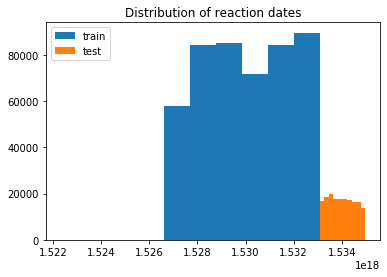

In [141]:
train_dates = stories_reaction_train['event_dttm']
train_dates = pd.to_datetime(train_dates,infer_datetime_format=True).astype(np.int64)
test_dates = stories_reaction_test['event_dttm']
test_dates = pd.to_datetime(test_dates,infer_datetime_format=True).astype(np.int64) 
plt.hist(train_dates.astype(np.int64) , label='train');
plt.hist(test_dates, label='test');
plt.legend();
plt.title('Distribution of reaction dates');

In [155]:
transactions_customers = set(transactions.customer_id.values)
print(f'customers in transctions {len(transactions_customers)}')
print(f'customers in transctions and in reactions {len(all_customers_in_train_test.intersection(transactions_customers))}')



customers in transctions 46948
customers in transctions and in reactions 43036


In [ ]:
?? customer may have only view but not like and other reactions??
?? 